In [51]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt

# Importing the dataset

In [36]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 32', axis=1, inplace=True)

In [37]:
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

# Preprocessing

* Convert into numpy arrays
* Scale features
* Separate labels from features
* Split into train / test sets
* Convert to tensors

## Convert to numpy

In [38]:
data = df.to_numpy()

## Separate labels from features

In [39]:
labels = data[:, 1].reshape(569, 1)
train_y, test_y = labels[:284, 0], labels[284:568, 0]
data = data[:, 2:32]

## Convert letter labels into digits

In [40]:
for i in range(len(train_y)):
        if train_y[i] == 'M':
            train_y[i] = 1
        else:
            train_y[i] = 0

for i in range(len(train_y)):
        if test_y[i] == 'M':
            test_y[i] = 1
        else:
            test_y[i] = 0

## Check out distribution of labels

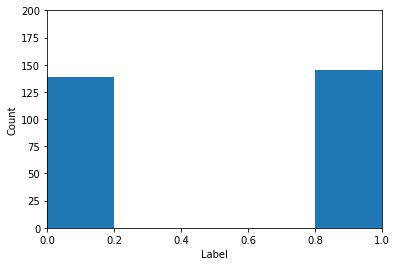

In [41]:
plt.hist(train_y, bins=5)
plt.axis([0, 1, 0, 200])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Convert label arrays to tensors

In [42]:
train_y = torch.from_numpy(train_y.astype(np.float32)).reshape(train_y.shape[0], 1)
test_y = torch.from_numpy(test_y.astype(np.float32)).reshape(test_y.shape[0], 1)

## Perform feature scaling

In [43]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

## Separate remaining features into train / test sets & convert to tensors

In [44]:
train_feats = torch.from_numpy(data[:284].astype(np.float32))
test_feats = torch.from_numpy(data[284:568].astype(np.float32))

# Create logistic regression model to following specs:

* The only layers will be the input and output layers
* The two layers are fully connected
* Output is computed with the sigmoid function

In [45]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim):
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(30, 1)

    def forward(self, x):
        b = torch.sigmoid(self.output(x))
        return b

# Initialize model along with its loss function and optimizer

In [46]:
m = LogisticRegression(30)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=.001)

# Minimize cost function to find optimal weights

In [47]:
losses = list()
epochs = 700
for i in range(epochs):
    output = m(train_feats).reshape(284, 1)
    loss = criterion(output, train_y)
    if (i + 1) % 70 == 0:
        losses.append(loss.item())
    if (i + 1) % 100 == 0 or i == epochs - 1:
        print(f'epoch #{i}, loss: {loss}, weight: {m.output.weight}')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch #99, loss: 0.34451329708099365, weight: Parameter containing:
tensor([[-0.0230,  0.2417,  0.2158,  0.0219,  0.0020,  0.0695,  0.0525,  0.1130,
          0.1435,  0.0343,  0.0031, -0.0822,  0.0802,  0.1359, -0.1146,  0.0227,
          0.1252, -0.0786, -0.0986, -0.0251,  0.1982, -0.0112,  0.2317,  0.0674,
          0.0956,  0.0117, -0.0416,  0.0044,  0.0828,  0.0857]],
       requires_grad=True)
epoch #199, loss: 0.241904616355896, weight: Parameter containing:
tensor([[ 0.0317,  0.3037,  0.2697,  0.0757,  0.0488,  0.1113,  0.0963,  0.1636,
          0.1746, -0.0640,  0.0545, -0.1244,  0.1307,  0.1863, -0.0806,  0.0466,
          0.1183, -0.0350, -0.1791, -0.0886,  0.2533,  0.0519,  0.2860,  0.1212,
          0.1520,  0.0571,  0.0034,  0.0571,  0.1351,  0.1265]],
       requires_grad=True)
epoch #299, loss: 0.19252797961235046, weight: Parameter containing:
tensor([[ 0.0735,  0.3559,  0.3107,  0.1167,  0.0828,  0.1394,  0.1278,  0.2017,
          0.1922, -0.1447,  0.0946, -0.1413, 

# Plot loss through all epochs

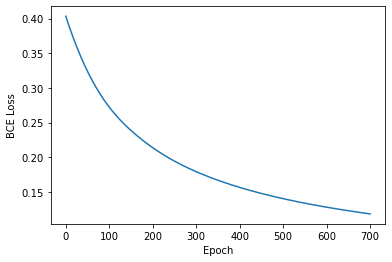

In [48]:
from scipy.interpolate import make_interp_spline, BSpline
x = np.linspace(0, 700, 10)
y = losses
x_new = np.linspace(x.min(), x.max(), 400)
spl = make_interp_spline(x, y)
y_smooth = spl(x_new)
plt.plot(x_new, y_smooth)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.show()

# Test accuracy against test set

In [49]:
with torch.no_grad():
    y_pred=m(test_feats)
    y_pred_class=y_pred.round()
    accuracy=((y_pred_class == test_y).sum()) / 284
    print(f'Accuracy: {round(accuracy.item() * 100, 1)}%')

Accuracy: 97.9%
